In [15]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,f1_score,precision_score,precision_recall_curve,roc_curve,roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
# Load your dataset (replace 'your_dataset.csv' with your dataset file)
df = pd.read_csv(r"D:\Bos\WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Dataset shape:", df.shape)
print(df.head())

# Convert TotalCharges to numeric if exists
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df.dropna(inplace=True)

# Target column conversion (assuming 'Churn')
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
else:
    raise ValueError("No 'Churn' column found in the dataset.")

# One-hot encode categorical features
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']



Dataset shape: (7043, 19)
   gender Partner Dependents  tenure PhoneService     MultipleLines  \
0  Female     Yes         No       1           No  No phone service   
1    Male      No         No      34          Yes                No   
2    Male      No         No       2          Yes                No   
3    Male      No         No      45           No  No phone service   
4  Female      No         No       2          Yes                No   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4     Fiber optic             No           No               No          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          N

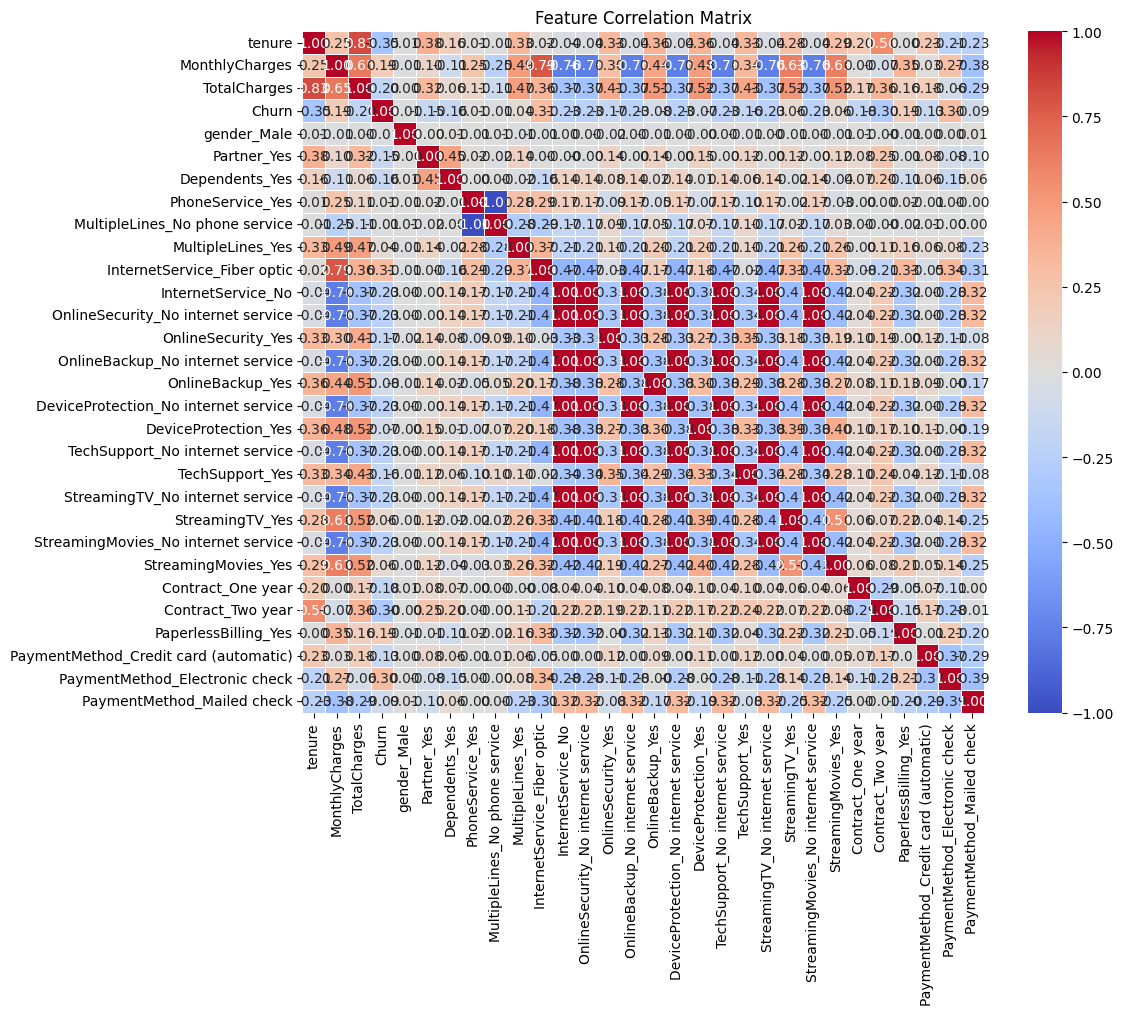


Top 10 Features Most Correlated with Churn:
Churn                             1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
MonthlyCharges                    0.192858
PaperlessBilling_Yes              0.191454
StreamingTV_Yes                   0.063254
StreamingMovies_Yes               0.060860
MultipleLines_Yes                 0.040033
PhoneService_Yes                  0.011691
gender_Male                      -0.008545
Name: Churn, dtype: float64


In [17]:
# Create correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format annotation to 2 decimal places
            square=True,  # Make cells square
            linewidths=0.5)  # Add lines between cells

plt.title('Feature Correlation Matrix')
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

# Get the most correlated features with Churn
churn_correlations = correlation_matrix['Churn'].sort_values(ascending=False)
print("\nTop 10 Features Most Correlated with Churn:")
print(churn_correlations[:10])

In [18]:
 #SCALE FEATURES
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
print("\nOriginal dataset class distribution:")
print(y.value_counts())


Original dataset class distribution:
Churn
0    5163
1    1869
Name: count, dtype: int64


In [19]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("\nAfter SMOTE class distribution:")
print(y_smote.value_counts())


After SMOTE class distribution:
Churn
0    5163
1    5163
Name: count, dtype: int64


In [20]:
latent_dim = 100

def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(X_smote.shape[1], activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(X_smote.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [21]:

generator = build_generator()
discriminator = build_discriminator()

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = tf.keras.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = build_gan(generator, discriminator)


Epoch 0, D Loss: 0.6812, G Loss: 0.7180
Epoch 20, D Loss: 0.6745, G Loss: 0.6848
Epoch 40, D Loss: 0.6962, G Loss: 0.6557
Epoch 60, D Loss: 0.7113, G Loss: 0.6277
Epoch 80, D Loss: 0.7280, G Loss: 0.6046
Epoch 100, D Loss: 0.7458, G Loss: 0.5801
Epoch 120, D Loss: 0.7606, G Loss: 0.5588
Epoch 140, D Loss: 0.7764, G Loss: 0.5398
Epoch 160, D Loss: 0.7915, G Loss: 0.5231
Epoch 180, D Loss: 0.8060, G Loss: 0.5074
Epoch 200, D Loss: 0.8204, G Loss: 0.4931
Epoch 220, D Loss: 0.8333, G Loss: 0.4807
Epoch 240, D Loss: 0.8456, G Loss: 0.4690
Epoch 260, D Loss: 0.8573, G Loss: 0.4587
Epoch 280, D Loss: 0.8686, G Loss: 0.4490
Epoch 300, D Loss: 0.8787, G Loss: 0.4394
Epoch 320, D Loss: 0.8883, G Loss: 0.4310
Epoch 340, D Loss: 0.8984, G Loss: 0.4227
Epoch 360, D Loss: 0.9075, G Loss: 0.4150
Epoch 380, D Loss: 0.9157, G Loss: 0.4080
Epoch 400, D Loss: 0.9237, G Loss: 0.4013
Epoch 420, D Loss: 0.9313, G Loss: 0.3946
Epoch 440, D Loss: 0.9385, G Loss: 0.3887
Epoch 460, D Loss: 0.9455, G Loss: 0.383

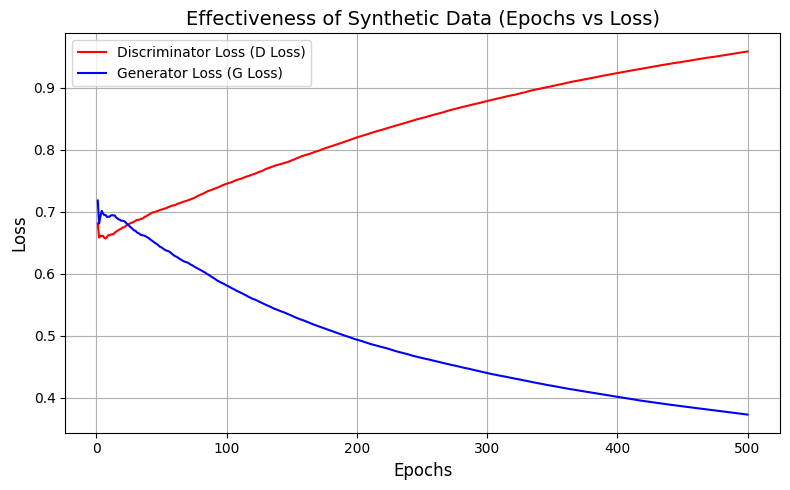

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def train_gan(generator, discriminator, gan, X_minority, epochs=500, batch_size=64, verbose=True):
    d_losses = []
    g_losses = []
    epoch_list = []

    for epoch in range(epochs):
        # Label smoothing for stability
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise, verbose=0)

        idx = np.random.randint(0, X_minority.shape[0], batch_size)
        real_data = X_minority.iloc[idx] if isinstance(X_minority, pd.DataFrame) else X_minority[idx]

        real_labels = np.ones((batch_size, 1)) * 0.9
        fake_labels = np.zeros((batch_size, 1)) + 0.1

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Save for plotting
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        epoch_list.append(epoch + 1)

        if verbose and epoch % 20 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

    # Plot D and G Loss vs Epoch
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_list, d_losses, label='Discriminator Loss (D Loss)', color='red', linewidth=1.5)
    plt.plot(epoch_list, g_losses, label='Generator Loss (G Loss)', color='blue', linewidth=1.5)
    plt.title('Effectiveness of Synthetic Data (Epochs vs Loss)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show(block=True)

# Train GAN on minority class only
X_minority = X_smote[y_smote==1]

train_gan(generator, discriminator, gan, X_minority, epochs=500, batch_size=64)

In [23]:
fraction = 0.3
num_to_generate = int(fraction * X_minority.shape[0])

noise = np.random.normal(0, 1, (num_to_generate, latent_dim))
synthetic_data = generator.predict(noise, verbose=0)
synthetic_df = pd.DataFrame(synthetic_data, columns=X_smote.columns)



# Combine SMOTE data + fractional GAN synthetic minority
X_augmented = pd.concat([X_smote, synthetic_df], ignore_index=True)
y_augmented = np.hstack([y_smote, np.ones(num_to_generate)])



Threshold=0.55, F1=0.8974

===== Random Forest =====
Best Threshold: 0.55
Accuracy: 0.8805, F1 Score: 0.8932, ROC-AUC: 0.9456
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       516
         1.0       0.90      0.88      0.89       672

    accuracy                           0.88      1188
   macro avg       0.88      0.88      0.88      1188
weighted avg       0.88      0.88      0.88      1188



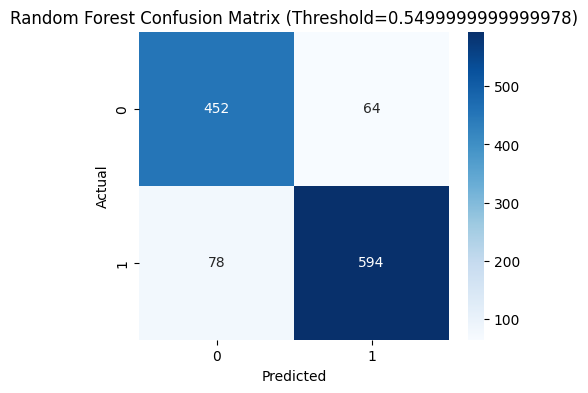

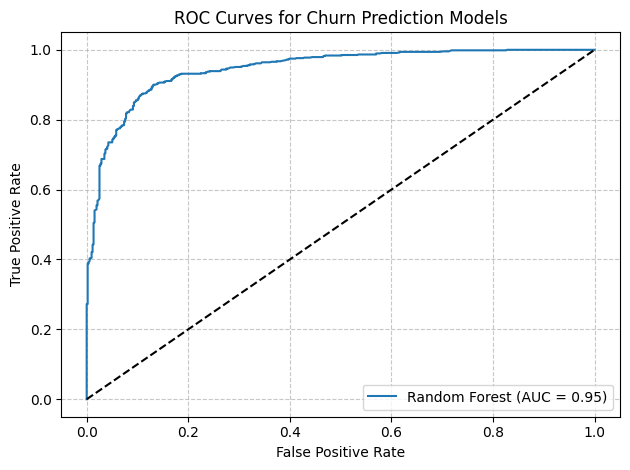

Threshold=0.55, F1=0.8361

===== Logistic Regression =====
Best Threshold: 0.55
Accuracy: 0.7938, F1 Score: 0.8114, ROC-AUC: 0.8816
              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77       516
         1.0       0.84      0.78      0.81       672

    accuracy                           0.79      1188
   macro avg       0.79      0.80      0.79      1188
weighted avg       0.80      0.79      0.79      1188



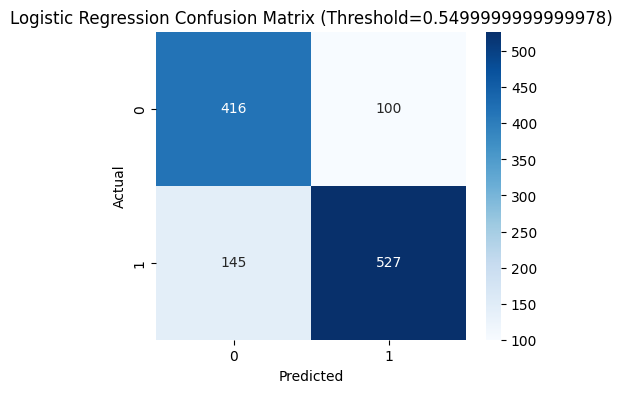

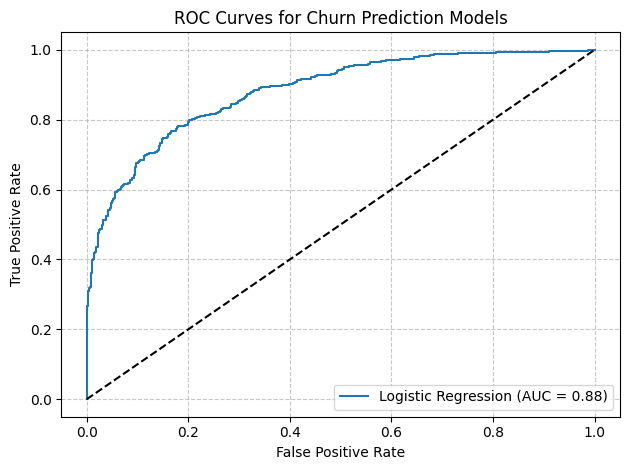

Threshold=0.55, F1=0.8354

===== Decision Tree =====
Best Threshold: 0.55
Accuracy: 0.8224, F1 Score: 0.8454, ROC-AUC: 0.8169
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79       516
         1.0       0.83      0.86      0.85       672

    accuracy                           0.82      1188
   macro avg       0.82      0.82      0.82      1188
weighted avg       0.82      0.82      0.82      1188



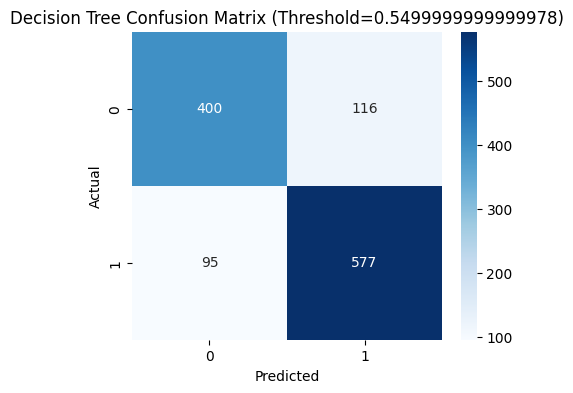

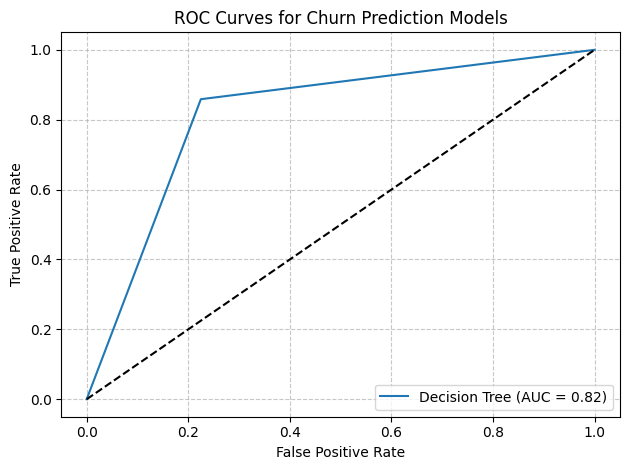

Threshold=0.55, F1=0.9092

===== XGBoost =====
Best Threshold: 0.55
Accuracy: 0.8830, F1 Score: 0.8976, ROC-AUC: 0.9499
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       516
         1.0       0.89      0.91      0.90       672

    accuracy                           0.88      1188
   macro avg       0.88      0.88      0.88      1188
weighted avg       0.88      0.88      0.88      1188



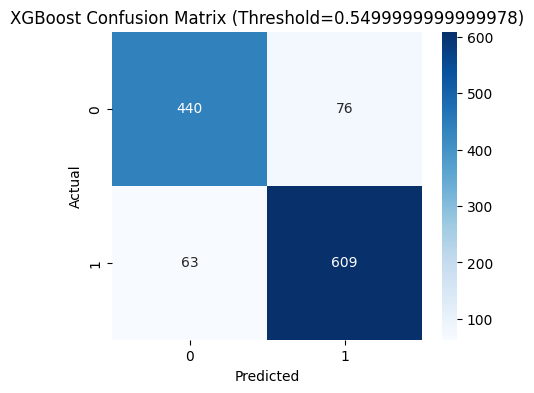

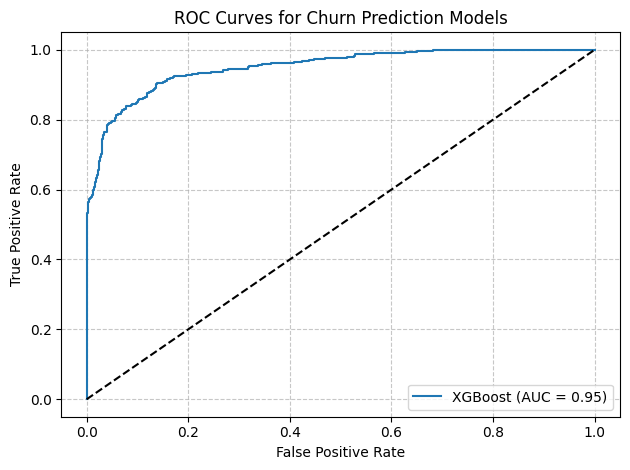

Threshold=0.55, F1=0.9067

===== LightGBM =====
Best Threshold: 0.55
Accuracy: 0.8721, F1 Score: 0.8866, ROC-AUC: 0.9496
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       516
         1.0       0.89      0.88      0.89       672

    accuracy                           0.87      1188
   macro avg       0.87      0.87      0.87      1188
weighted avg       0.87      0.87      0.87      1188



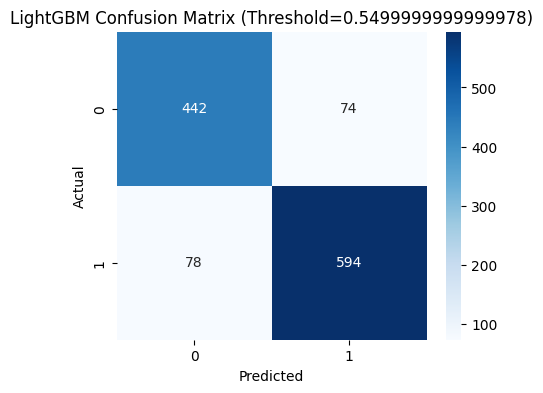

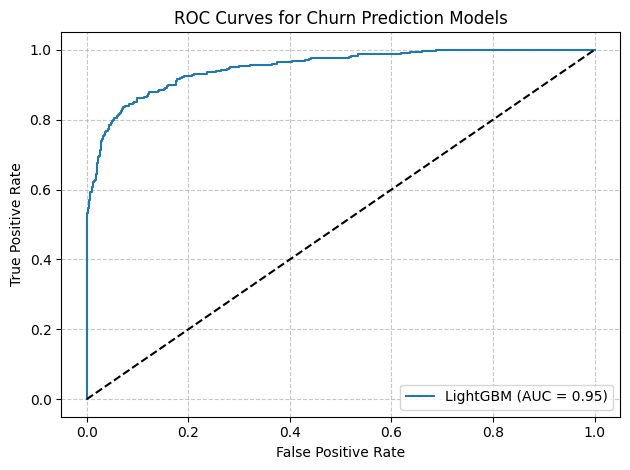

Threshold=0.55, F1=0.9088

===== CatBoost =====
Best Threshold: 0.55
Accuracy: 0.8855, F1 Score: 0.9000, ROC-AUC: 0.9553
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.87       516
         1.0       0.89      0.91      0.90       672

    accuracy                           0.89      1188
   macro avg       0.88      0.88      0.88      1188
weighted avg       0.89      0.89      0.89      1188



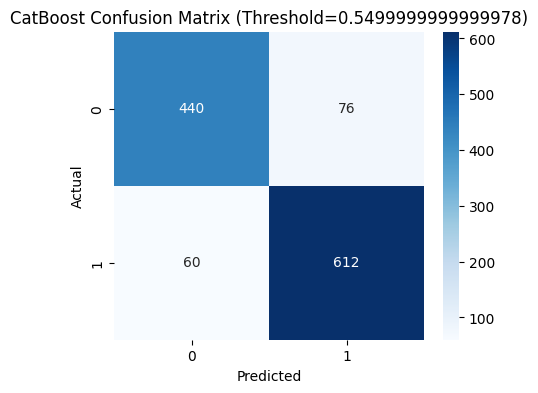

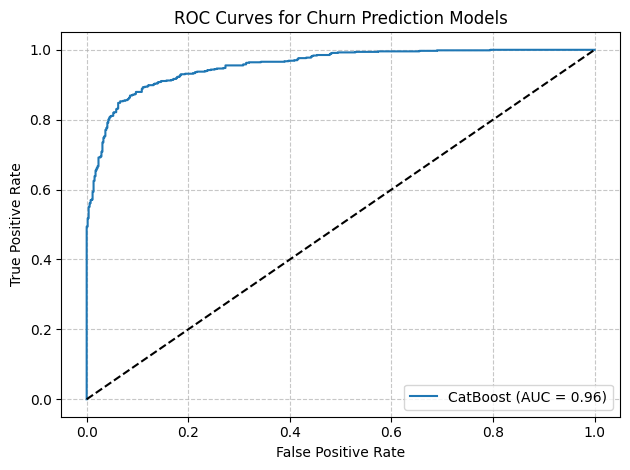


===== Model Comparison Summary =====
                 Model  Best Threshold  Accuracy  F1 Score  \
0        Random Forest            0.55  0.880471  0.893233   
1  Logistic Regression            0.55  0.793771  0.811393   
2        Decision Tree            0.55  0.822391  0.845421   
3              XGBoost            0.55  0.882997  0.897568   
4             LightGBM            0.55  0.872054  0.886567   
5             CatBoost            0.55  0.885522  0.900000   

   Precision (Churn=0)  Precision (Churn=1)  
0             0.852830             0.902736  
1             0.741533             0.840510  
2             0.808081             0.832612  
3             0.874751             0.889051  
4             0.850000             0.889222  
5             0.880000             0.889535  


In [24]:
# Train-test split on the augmented dataset 
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.10, random_state=42) 
# Create validation split from training set (for threshold tuning / model selection) 
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.10, random_state=42, stratify=y_train ) 
def tune_threshold(model, X_val, y_val, thresholds=np.arange(0.53, 0.55, 0.0005)): 
    y_val_probs = model.predict_proba(X_val)[:,1] 
    best_threshold = 0.5 
    best_f1 = 0 
    for t in thresholds: 
         y_val_pred = (y_val_probs >= t).astype(int)    
         f1 = f1_score(y_val, y_val_pred)  
         #optional debug 
         if f1 > best_f1: best_f1 = f1 
         best_threshold = t
    print(f"Threshold={t:.2f}, F1={f1:.4f}") 
    return best_threshold 
def plot_confusion(y_true, y_pred, model_name, threshold): 
    cm = confusion_matrix(y_true, y_pred) 
    plt.figure(figsize=(5,4)) 
    sns.heatmap(cm, annot=True, 
    fmt='d', cmap='Blues') 
    plt.title(f'{model_name} Confusion Matrix (Threshold={threshold})') 
    plt.xlabel('Predicted') 
    plt.ylabel('Actual') 
    plt.show() 
# List of ML models 
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=1000,
        max_depth=40,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        class_weight={0: 1, 1: 1.1},  # Slight bias towards minority
        n_jobs=-1,
        criterion='gini'
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=500,
        class_weight='balanced',
        random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=40,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        class_weight={0: 1, 1: 1.1},
        criterion='gini'
    ),
    "XGBoost": XGBClassifier(
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.015,
        subsample=0.95,
        colsample_bytree=0.95,
        gamma=0.8,
        reg_alpha=0.3,
        reg_lambda=0.8,
        min_child_weight=1,
        scale_pos_weight=1.05,  # Slight boost to positive class
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
        tree_method='hist'
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.015,
        num_leaves=70,
        subsample=0.95,
        colsample_bytree=0.95,
        reg_alpha=0.3,
        reg_lambda=0.8,
        min_child_samples=4,
        random_state=42,
        class_weight={0: 1, 1: 1.1},
        verbose=-1,
        n_jobs=-1,
        boosting_type='gbdt'
    ),
    "CatBoost": CatBoostClassifier(
        iterations=1000,
        depth=12,
        learning_rate=0.015,
        l2_leaf_reg=2.5,
        random_strength=0.4,
        bagging_temperature=0.15,
        border_count=128,
        random_state=42,
        verbose=0,
        thread_count=-1,
        class_weights={0: 1, 1: 1.1}
    )
} 
# ==============================
# Train, tune threshold & evaluate for each model 
# ============================== 
Smote_Gan = [] 
for name, model in models.items(): 
        #Train model 
        model.fit(X_train, y_train) 
        # Find best threshold using validation set 
        best_threshold = tune_threshold(model, X_val, y_val) 
        # Predict on test set using best threshold 
        y_probs = model.predict_proba(X_test)[:,1] 
        y_pred = (y_probs >= best_threshold).astype(int) 
        # Evaluation metrics 
        acc = accuracy_score(y_test, y_pred) 
        f1 = f1_score(y_test, y_pred) 
        precision_0 = precision_score(y_test, y_pred, pos_label=0) 
        precision_1 = precision_score(y_test, y_pred, pos_label=1) 
        roc_auc_score_val = roc_auc_score(y_test, y_probs)


        print(f"\n===== {name} =====") 
        print(f"Best Threshold: {best_threshold:.2f}") 
        print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc_score_val:.4f}") 
        print(classification_report(y_test, y_pred)) 
        # Confusion matrix 
        plot_confusion(y_test, y_pred, name, best_threshold) 
        # ROC curve for the model
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score_val:.2f})")
        # Store results 
        Smote_Gan.append({ "Model": name, 
                          "Best Threshold": best_threshold, 
                          "Accuracy": acc, 
                          "F1 Score": f1, 
                          "Precision (Churn=0)": precision_0, 
                          "Precision (Churn=1)": precision_1 }) 
        # Finalize ROC plot
        plt.plot([0,1], [0,1], 'k--')  # diagonal
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves for Churn Prediction Models")
        plt.legend(loc="lower right")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
# ============================== 
#Summary table 
# ============================== 
results_df = pd.DataFrame(Smote_Gan) 
print("\n===== Model Comparison Summary =====") 
print(results_df)



===== Random Forest =====
Best Threshold: 0.40
Accuracy: 0.7685, F1 Score: 0.5722
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       517
           1       0.56      0.58      0.57       187

    accuracy                           0.77       704
   macro avg       0.70      0.71      0.71       704
weighted avg       0.77      0.77      0.77       704



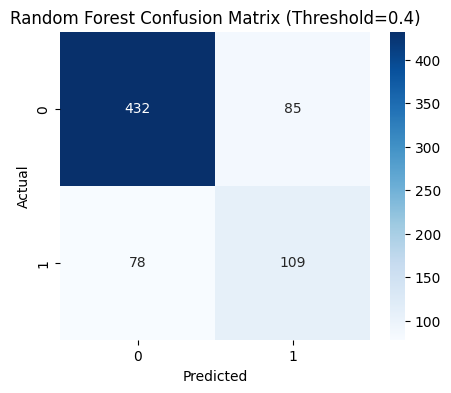

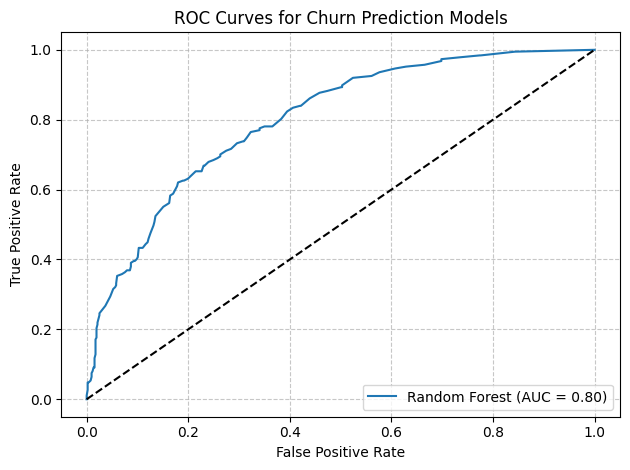


===== Logistic Regression =====
Best Threshold: 0.51
Accuracy: 0.7244, F1 Score: 0.5924
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       517
           1       0.49      0.75      0.59       187

    accuracy                           0.72       704
   macro avg       0.69      0.73      0.69       704
weighted avg       0.78      0.72      0.74       704



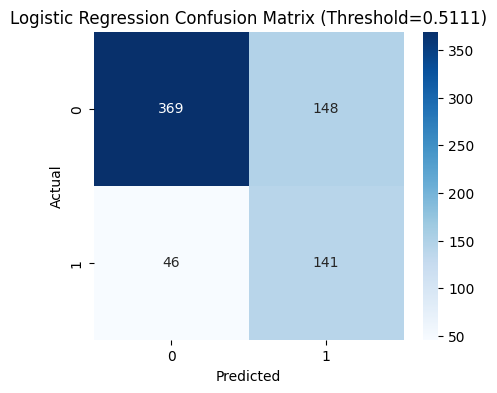

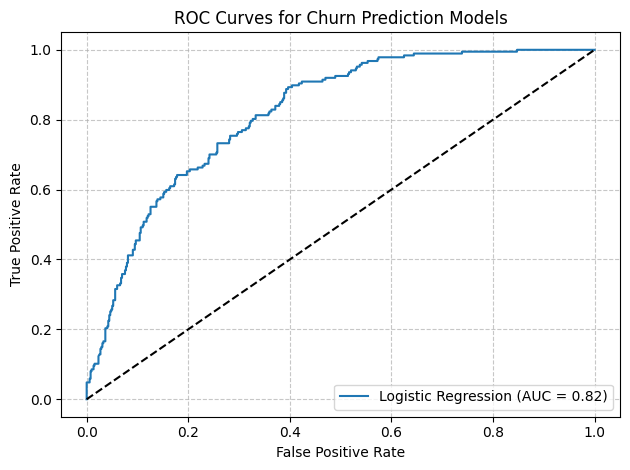


===== Decision Tree =====
Best Threshold: 0.40
Accuracy: 0.6989, F1 Score: 0.4144
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       517
           1       0.43      0.40      0.41       187

    accuracy                           0.70       704
   macro avg       0.61      0.60      0.61       704
weighted avg       0.69      0.70      0.70       704



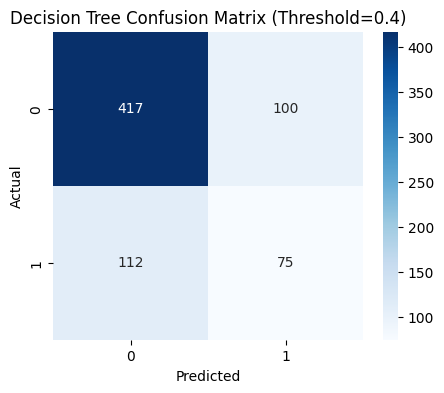

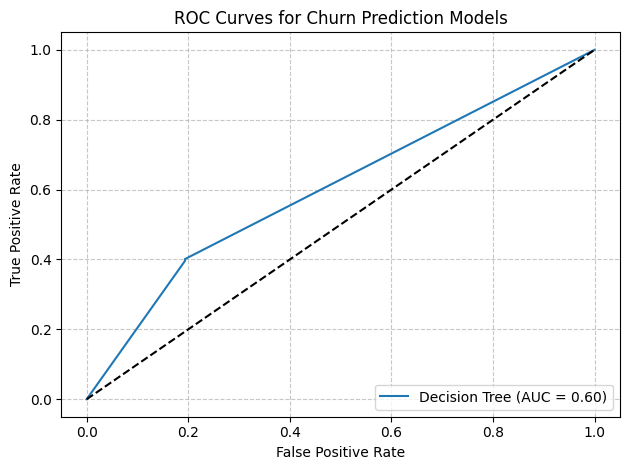


===== XGBoost =====
Best Threshold: 0.40
Accuracy: 0.7330, F1 Score: 0.5179
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       517
           1       0.50      0.54      0.52       187

    accuracy                           0.73       704
   macro avg       0.66      0.67      0.67       704
weighted avg       0.74      0.73      0.74       704



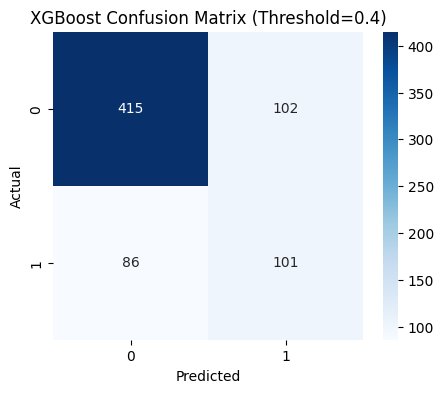

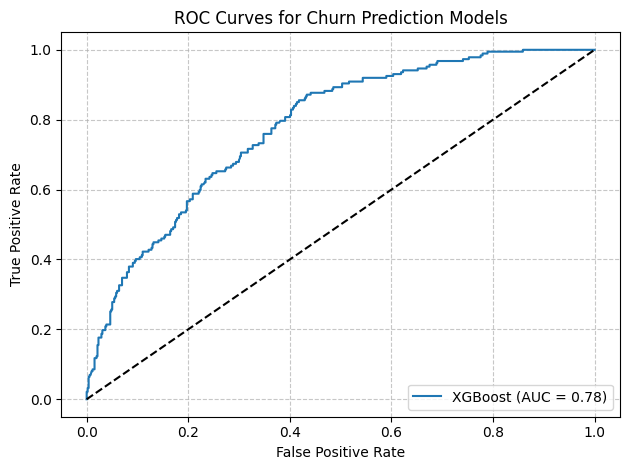


===== LightGBM =====
Best Threshold: 0.40
Accuracy: 0.7017, F1 Score: 0.5833
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       517
           1       0.46      0.79      0.58       187

    accuracy                           0.70       704
   macro avg       0.68      0.73      0.68       704
weighted avg       0.78      0.70      0.72       704



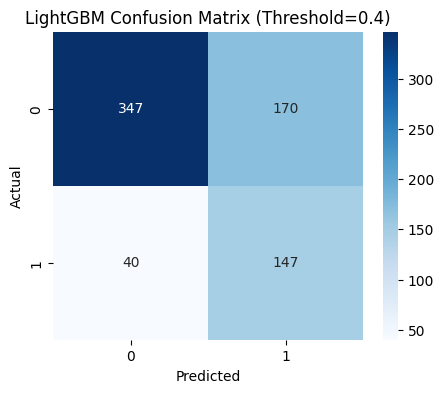

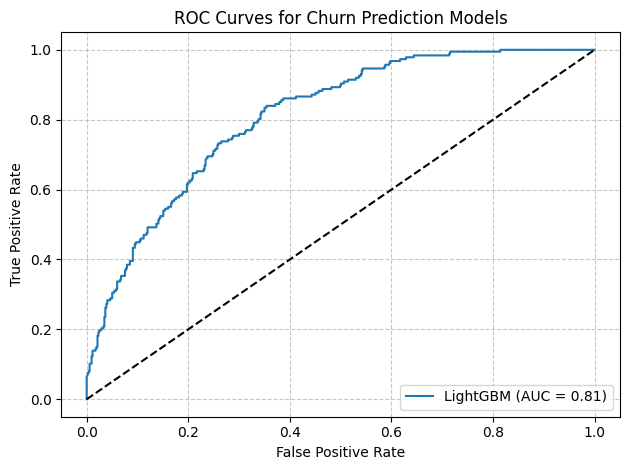


===== CatBoost =====
Best Threshold: 0.40
Accuracy: 0.7699, F1 Score: 0.5909
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       517
           1       0.56      0.63      0.59       187

    accuracy                           0.77       704
   macro avg       0.71      0.72      0.72       704
weighted avg       0.78      0.77      0.77       704



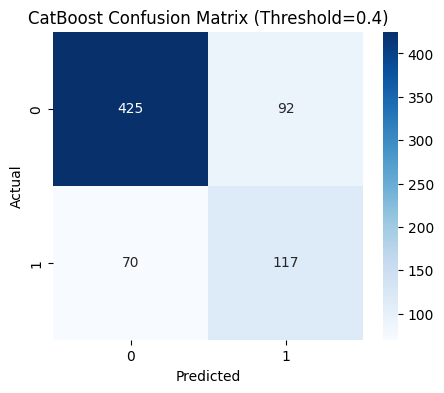

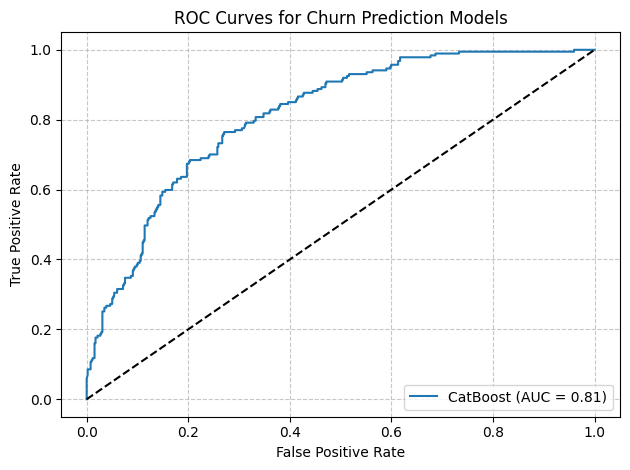


===== Model Comparison Summary =====
                 Model  Best Threshold  Accuracy  F1 Score  \
0        Random Forest          0.4000  0.768466  0.572178   
1  Logistic Regression          0.5111  0.724432  0.592437   
2        Decision Tree          0.4000  0.698864  0.414365   
3              XGBoost          0.4000  0.732955  0.517949   
4             LightGBM          0.4000  0.701705  0.583333   
5             CatBoost          0.4000  0.769886  0.590909   

   Precision (Churn=0)  Precision (Churn=1)  
0             0.847059             0.561856  
1             0.889157             0.487889  
2             0.788280             0.428571  
3             0.828343             0.497537  
4             0.896641             0.463722  
5             0.858586             0.559809  


In [ ]:
import warnings
warnings.filterwarnings("ignore")
# ==============================
# Train-test split on the ORIGINAL dataset
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42, stratify=y
)

# Create validation split from training set (for threshold tuning / model selection)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# ==============================
# Threshold tuning function (same as before)
# ==============================
def tune_threshold(model, X_val, y_val, thresholds=np.arange(0.4, 0.6, 0.1111)):
    y_val_probs = model.predict_proba(X_val)[:,1]
    best_threshold = 0.5
    best_f1 = 0
    for t in thresholds:
        y_val_pred = (y_val_probs >= t).astype(int)
        f1 = f1_score(y_val, y_val_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    return best_threshold

# ==============================
# Confusion matrix plotting
# ==============================
def plot_confusion(y_true, y_pred, model_name, threshold):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix (Threshold={threshold})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ==============================
# List of ML models
# ==============================
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42, class_weight='balanced',verbose=-1),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

# ==============================
# Train, tune threshold & evaluate for each model
# ==============================
results = []

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Find best threshold using validation set
    best_threshold = tune_threshold(model, X_val, y_val)
    
    # Predict on test set using best threshold
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = (y_probs >= best_threshold).astype(int)
    
    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    roc_auc_score_val = roc_auc_score(y_test, y_probs)
    
    print(f"\n===== {name} =====")
    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plot_confusion(y_test, y_pred, name, best_threshold)

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score_val:.2f})")
    
    # Store results
    results.append({
        "Model": name,
        "Best Threshold": best_threshold,
        "Accuracy": acc,
        "F1 Score": f1,
        "Precision (Churn=0)": precision_0,
        "Precision (Churn=1)": precision_1
    })
    # Finalize ROC plot
    plt.plot([0,1], [0,1], 'k--')  # diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Churn Prediction Models")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ==============================
# Summary table
# ==============================
original = pd.DataFrame(results)
print("\n===== Model Comparison Summary =====")
print(original)




===== SMOTE+GAN Model Comparison Summary (Churn=1) =====
                 Model  Accuracy - Original  F1 Score - Original  \
0        Random Forest             0.768466             0.572178   
1  Logistic Regression             0.724432             0.592437   
2        Decision Tree             0.698864             0.414365   
3              XGBoost             0.732955             0.517949   
4             LightGBM             0.701705             0.583333   
5             CatBoost             0.769886             0.590909   

   Precision (Churn=1) - Original  Accuracy - SMOTE+GAN  F1 Score - SMOTE+GAN  \
0                        0.561856              0.880471              0.893233   
1                        0.487889              0.793771              0.811393   
2                        0.428571              0.822391              0.845421   
3                        0.497537              0.882997              0.897568   
4                        0.463722              0.872054     

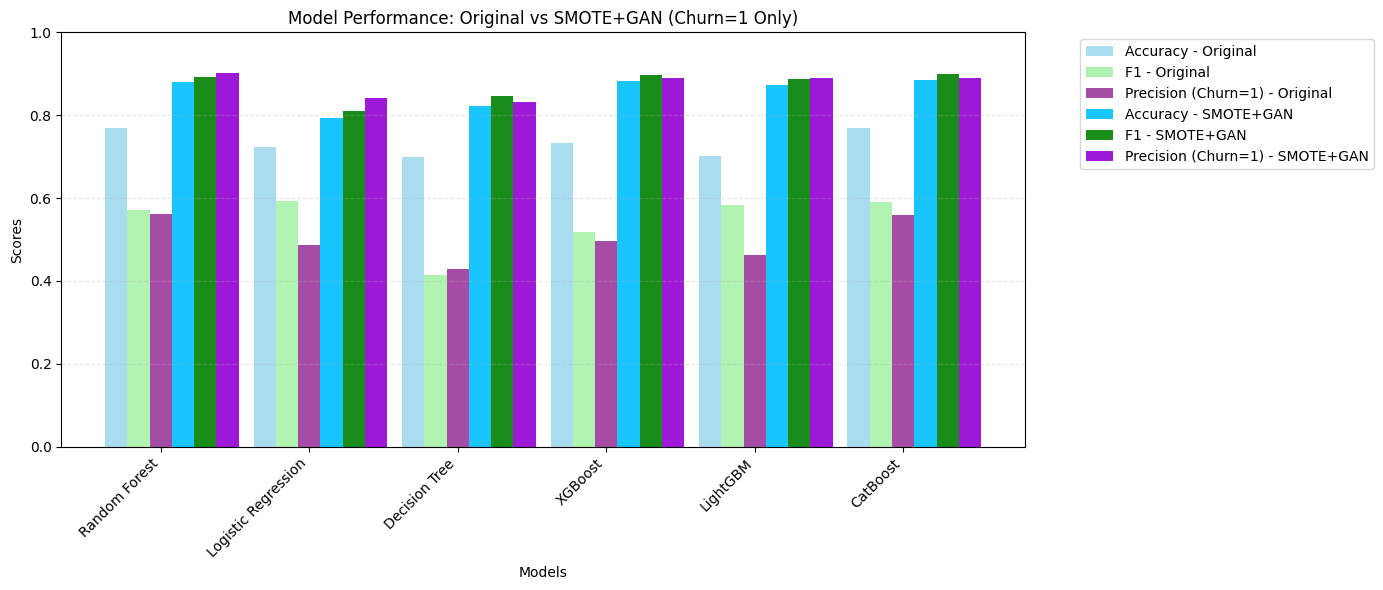

In [26]:
# Summary table
original_traning_df=pd.DataFrame(original)
results_df = pd.DataFrame(Smote_Gan)
# ==============================
# Merge Original vs SMOTE+GAN for Churn=1
# ==============================
training_summary_df = pd.merge(
    pd.DataFrame(original), 
    pd.DataFrame(Smote_Gan), 
    on='Model', 
    suffixes=(" - Original", " - SMOTE+GAN")
)

# Keep only Churn=1 metrics plus Accuracy and F1
training_summary_df = training_summary_df[[
    "Model",
    "Accuracy - Original",
    "F1 Score - Original",
    "Precision (Churn=1) - Original",
    "Accuracy - SMOTE+GAN",
    "F1 Score - SMOTE+GAN",
    "Precision (Churn=1) - SMOTE+GAN"
]]

print("\n===== SMOTE+GAN Model Comparison Summary (Churn=1) =====")
print(training_summary_df)

# ==============================
# Plot performance comparison (Churn=1 only)
# ==============================
plt.figure(figsize=(14, 6))
models_names = training_summary_df['Model']
x = np.arange(len(models_names))
width = 0.15

# Plot Original metrics
plt.bar(x - width, training_summary_df['Accuracy - Original'], width, label='Accuracy - Original', color='skyblue', alpha=0.7)
plt.bar(x, training_summary_df['F1 Score - Original'], width, label='F1 - Original', color='lightgreen', alpha=0.7)
plt.bar(x + width, training_summary_df['Precision (Churn=1) - Original'], width, label='Precision (Churn=1) - Original', color='purple', alpha=0.7)

# Plot SMOTE+GAN metrics
plt.bar(x - width + 3*width, training_summary_df['Accuracy - SMOTE+GAN'], width, label='Accuracy - SMOTE+GAN', color='deepskyblue', alpha=0.9)
plt.bar(x + 3*width, training_summary_df['F1 Score - SMOTE+GAN'], width, label='F1 - SMOTE+GAN', color='green', alpha=0.9)
plt.bar(x + width + 3*width, training_summary_df['Precision (Churn=1) - SMOTE+GAN'], width, label='Precision (Churn=1) - SMOTE+GAN', color='darkviolet', alpha=0.9)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance: Original vs SMOTE+GAN (Churn=1 Only)')
plt.xticks(x + width, models_names, rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



Visualizing relationships between key features and churn...


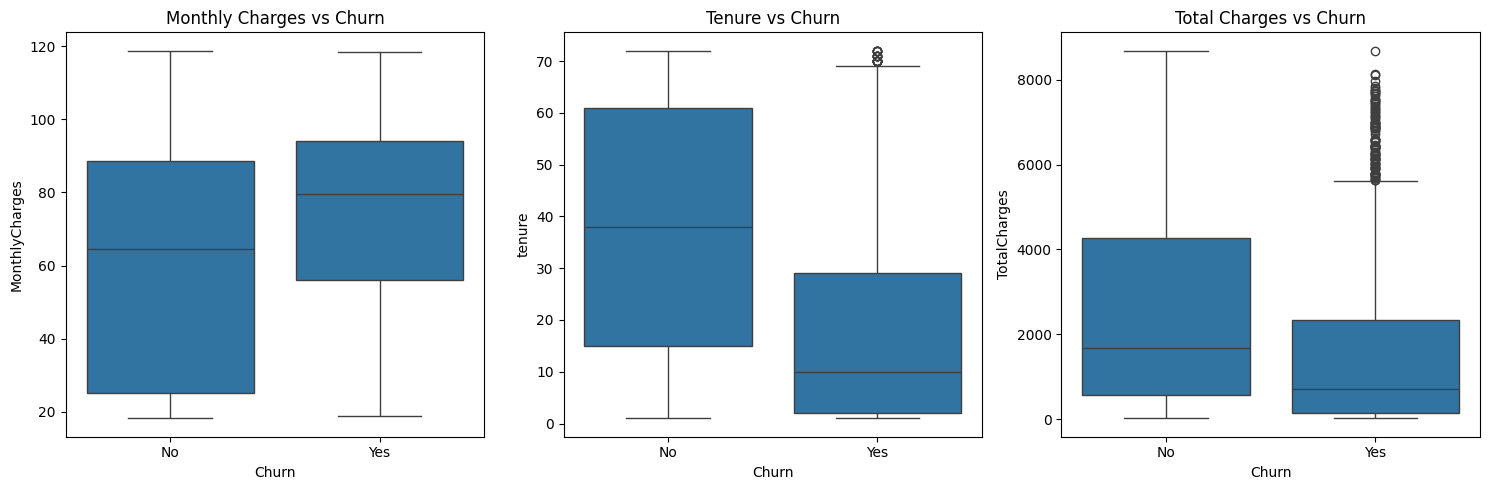

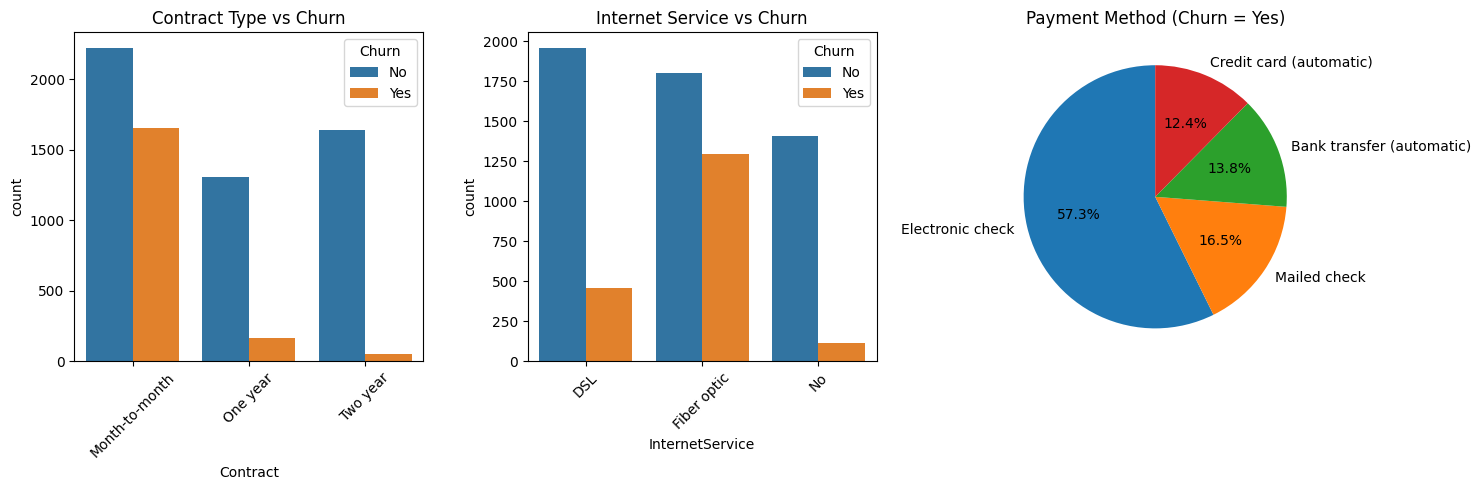

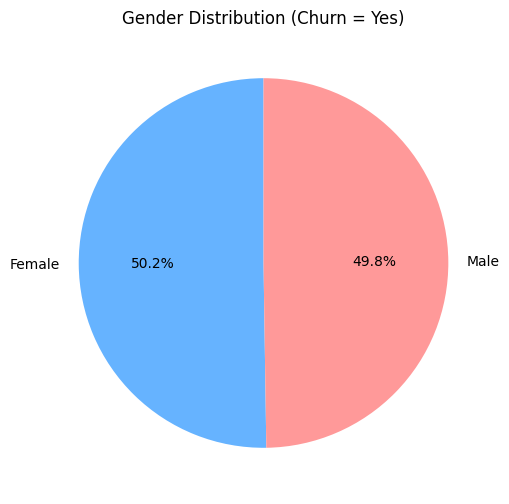

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function for plotting relationships
def plot_feature_relationships():
    # Load the original dataset
    original_df = pd.read_csv(r"D:\Bos\WA_Fn-UseC_-Telco-Customer-Churn.csv")

    # Clean TotalCharges column
    original_df['TotalCharges'] = pd.to_numeric(original_df['TotalCharges'], errors='coerce')
    original_df.dropna(inplace=True)

    # Strip extra spaces from column names
    original_df.columns = original_df.columns.str.strip()

    # Filter churned customers once (used later for pie charts)
    churned_df = original_df[original_df['Churn'] == 'Yes']

    # ------------------------------
    # Numerical Features vs Churn
    # ------------------------------
    plt.figure(figsize=(15, 5))

    # Monthly Charges   
    plt.subplot(1, 3, 1)
    sns.boxplot(x='Churn', y='MonthlyCharges', data=original_df)
    plt.title('Monthly Charges vs Churn')

    # Tenure
    plt.subplot(1, 3, 2)
    sns.boxplot(x='Churn', y='tenure', data=original_df)
    plt.title('Tenure vs Churn')

    # Total Charges
    plt.subplot(1, 3, 3)
    sns.boxplot(x='Churn', y='TotalCharges', data=original_df)
    plt.title('Total Charges vs Churn')

    plt.tight_layout()
    plt.show()

    # ------------------------------
    # Categorical Features vs Churn
    # ------------------------------
    plt.figure(figsize=(15, 5))

    # Contract Type
    plt.subplot(1, 3, 1)
    sns.countplot(data=original_df, x='Contract', hue='Churn')
    plt.title('Contract Type vs Churn')
    plt.xticks(rotation=45)

    # Internet Service
    plt.subplot(1, 3, 2)
    sns.countplot(data=original_df, x='InternetService', hue='Churn')
    plt.title('Internet Service vs Churn')
    plt.xticks(rotation=45)

    # Payment Method (only churned)
    plt.subplot(1, 3, 3)
    payment_counts = churned_df['PaymentMethod'].value_counts()
    plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Payment Method (Churn = Yes)')

    plt.tight_layout()
    plt.show()

    # ------------------------------
    # Gender distribution (only churned)
    # ------------------------------
    plt.figure(figsize=(6, 6))
    gender_counts = churned_df['gender'].value_counts()
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
    plt.title('Gender Distribution (Churn = Yes)')
    plt.show()


print("Visualizing relationships between key features and churn...")
plot_feature_relationships()



# Model Performance Comparison: Original vs SMOTE+GAN

Below is a detailed comparison of model performances between the original dataset and SMOTE+GAN augmented dataset. The comparison includes:

1. **Accuracy**: Overall prediction accuracy
2. **F1 Score**: Balance between precision and recall
3. **Precision**: Precision for the minority class (Churn=1)

The results are presented in both tabular form and visualizations.